In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
data = pd.read_csv('out.csv')
data.drop('Unnamed: 0', axis = 1, inplace = True)
data.drop('datetime', axis = 1, inplace = True)
data.total = data.total.astype(float)

In [3]:
data.weekDay.value_counts

<bound method IndexOpsMixin.value_counts of 0        5.0
1        5.0
2        5.0
3        5.0
4        5.0
        ... 
35059    2.0
35060    2.0
35061    2.0
35062    2.0
35063    2.0
Name: weekDay, Length: 35064, dtype: float64>

In [4]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [6]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    print(data.head())
    data.columns = ["total"]
    print(data.head())
    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.total.shift(i)

    # data.index = data.index.to_datetime()
    # data["hour"] = data.index.hour
    # data["weekday"] = data.index.weekday
    # data['is_weekend'] = data.weekday.isin([5,6])*1

    # выкидываем закодированные средними признаки 
    #data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    print(data.head())
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["total"], axis=1)
    y_train = data.loc[:test_index]["total"]
    X_test = data.loc[test_index:].drop(["total"], axis=1)
    y_test = data.loc[test_index:]["total"]
    
    print(X_train.head())
    print(y_train.head())
    
    return X_train, X_test, y_train, y_test

In [7]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(data.total, lag_start, lag_end, test_size)
    
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    # print(dtrain)
    # print(dtest)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

C:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [8]:
data.head()

,total,month,weekDay,day,hour,isHoliday
0,154140.0,1,5.0,1,0,0
1,154140.0,1,5.0,1,1,0
2,157818.0,1,5.0,1,2,0
3,149311.0,1,5.0,1,3,0
4,138282.0,1,5.0,1,4,0


In [9]:
XGB_forecast(data, test_size=0.2, lag_start=5, lag_end=30)

      total
0  154140.0
1  154140.0
2  157818.0
3  149311.0
4  138282.0
      total
0  154140.0
1  154140.0
2  157818.0
3  149311.0
4  138282.0
      total     lag_5     lag_6     lag_7     lag_8     lag_9    lag_10  \
0  116876.0  171760.0  200140.0  200878.0  196617.0  194657.0  198567.0   
1  124876.0  145727.0  171760.0  200140.0  200878.0  196617.0  194657.0   
2  135028.0  127815.0  145727.0  171760.0  200140.0  200878.0  196617.0   
3  152747.0  120269.0  127815.0  145727.0  171760.0  200140.0  200878.0   
4  191487.0  117395.0  120269.0  127815.0  145727.0  171760.0  200140.0   

     lag_11    lag_12    lag_13  ...    lag_20    lag_21    lag_22    lag_23  \
0  197123.0  197159.0  200407.0  ...  158872.0  138040.0  131026.0  129193.0   
1  198567.0  197123.0  197159.0  ...  189733.0  158872.0  138040.0  131026.0   
2  194657.0  198567.0  197123.0  ...  213830.0  189733.0  158872.0  138040.0   
3  196617.0  194657.0  198567.0  ...  219684.0  213830.0  189733.0  158872.0   
4  20

C:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


ValueError: could not convert string to float: '-nan(ind)'

      total
0  154140.0
1  154140.0
2  157818.0
3  149311.0
4  138282.0
      total
0  154140.0
1  154140.0
2  157818.0
3  149311.0
4  138282.0


C:\Users\AACE~1\AppData\Local\Temp/ipykernel_13740/2479318773.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["lag_{}".format(i)] = data.total.shift(i)
C:\Users\AACE~1\AppData\Local\Temp/ipykernel_13740/2479318773.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["lag_{}".format(i)] = data.total.shift(i)
C:\Users\AACE~1\AppData\Local\Temp/ipykernel_13740/2479318773.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

      total  lag_4380  lag_4381  lag_4382  lag_4383  lag_4384  lag_4385  \
0  178539.0  211577.0  210104.0  198790.0  178677.0  150969.0  135468.0   
1  135295.0  209446.0  211577.0  210104.0  198790.0  178677.0  150969.0   
2  150650.0  204835.0  209446.0  211577.0  210104.0  198790.0  178677.0   
3  150373.0  197686.0  204835.0  209446.0  211577.0  210104.0  198790.0   
4  142028.0  191290.0  197686.0  204835.0  209446.0  211577.0  210104.0   

   lag_4386  lag_4387  lag_4388  ...  lag_8750  lag_8751  lag_8752  lag_8753  \
0  118052.0  111313.0  113113.0  ...  158872.0  138040.0  131026.0  129193.0   
1  135468.0  118052.0  111313.0  ...  189733.0  158872.0  138040.0  131026.0   
2  150969.0  135468.0  118052.0  ...  213830.0  189733.0  158872.0  138040.0   
3  178677.0  150969.0  135468.0  ...  219684.0  213830.0  189733.0  158872.0   
4  198790.0  178677.0  150969.0  ...  216534.0  219684.0  213830.0  189733.0   

   lag_8754  lag_8755  lag_8756  lag_8757  lag_8758  lag_8759  
0  1

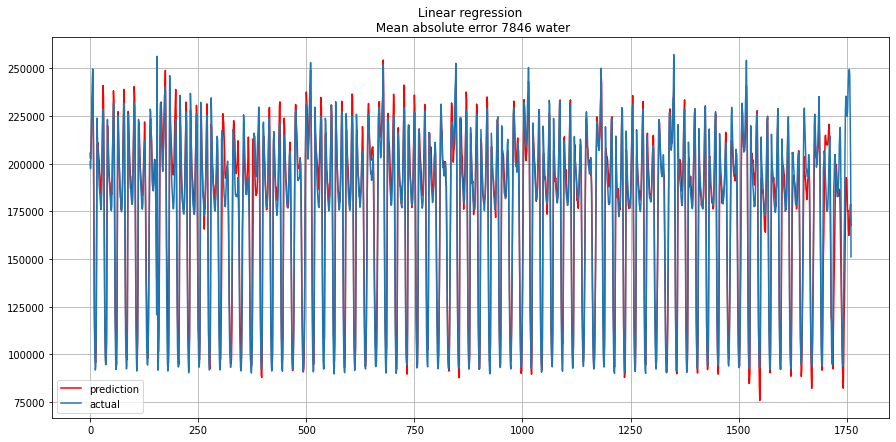

In [13]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(data.total, test_size=0.3, lag_start=4380, lag_end=8760)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} water".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True)

In [14]:
X_test

,lag_4380,lag_4381,lag_4382,lag_4383,lag_4384,lag_4385,lag_4386,lag_4387,lag_4388,lag_4389,...,lag_8750,lag_8751,lag_8752,lag_8753,lag_8754,lag_8755,lag_8756,lag_8757,lag_8758,lag_8759
24544,96909.0,104582.0,124270.0,160970.0,191701.0,210982.0,216077.0,208261.0,199524.0,195838.0,...,136747.0,171227.0,198004.0,204898.0,218818.0,213198.0,215193.0,207832.0,203206.0,208236.0
24545,93873.0,96909.0,104582.0,124270.0,160970.0,191701.0,210982.0,216077.0,208261.0,199524.0,...,120884.0,136747.0,171227.0,198004.0,204898.0,218818.0,213198.0,215193.0,207832.0,203206.0
24546,97407.0,93873.0,96909.0,104582.0,124270.0,160970.0,191701.0,210982.0,216077.0,208261.0,...,109273.0,120884.0,136747.0,171227.0,198004.0,204898.0,218818.0,213198.0,215193.0,207832.0
24547,111377.0,97407.0,93873.0,96909.0,104582.0,124270.0,160970.0,191701.0,210982.0,216077.0,...,103704.0,109273.0,120884.0,136747.0,171227.0,198004.0,204898.0,218818.0,213198.0,215193.0
24548,131937.0,111377.0,97407.0,93873.0,96909.0,104582.0,124270.0,160970.0,191701.0,210982.0,...,105748.0,103704.0,109273.0,120884.0,136747.0,171227.0,198004.0,204898.0,218818.0,213198.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26300,188953.0,148778.0,106833.0,91915.0,91801.0,95672.0,114224.0,162053.0,189583.0,202353.0,...,97101.0,96108.0,100368.0,112054.0,127018.0,151588.0,167665.0,168914.0,174792.0,170566.0
26301,194968.0,188953.0,148778.0,106833.0,91915.0,91801.0,95672.0,114224.0,162053.0,189583.0,...,102731.0,97101.0,96108.0,100368.0,112054.0,127018.0,151588.0,167665.0,168914.0,174792.0
26302,187568.0,194968.0,188953.0,148778.0,106833.0,91915.0,91801.0,95672.0,114224.0,162053.0,...,112212.0,102731.0,97101.0,96108.0,100368.0,112054.0,127018.0,151588.0,167665.0,168914.0
26303,168757.0,187568.0,194968.0,188953.0,148778.0,106833.0,91915.0,91801.0,95672.0,114224.0,...,125319.0,112212.0,102731.0,97101.0,96108.0,100368.0,112054.0,127018.0,151588.0,167665.0


In [15]:
xx = X_test.tail(1)


In [16]:
x_pred = X_test.tail(1)
cols = x_pred.columns
x_pred = list(x_pred.values[0])
x_pred[0]

174198.0

In [20]:
answer = []

for i in range(4344):
    d = {}
    j=0
    for c in cols:
        d[c] = [x_pred[j]]
        j+=1
    
    to_predict = pd.DataFrame(d)
    
    if i%100==0:
        print(i)
    my_pred = lr.predict(to_predict)
    answer.append(my_pred[0])
    #print(my_pred[0])
    x_pred.pop(-1)
    x_pred.insert(0, my_pred[0])

x_pred

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300


[77327.53145523989,
 71127.58051875717,
 74407.69358743593,
 95639.45139596978,
 130167.30957219074,
 168575.48069122707,
 195964.0747883782,
 208310.46256967838,
 203878.14336052275,
 182004.60086086934,
 164280.6339153598,
 158970.35732465406,
 163331.24252711167,
 170048.289218876,
 177415.30388237102,
 187399.73401244247,
 195929.25833757364,
 198057.99751009568,
 191830.5492243243,
 171454.37344329807,
 139297.45701322955,
 112213.9279298532,
 87063.71063678886,
 74083.81254277503,
 68393.40911336182,
 70784.86775612668,
 82141.78954442072,
 106797.39610118954,
 139080.823415776,
 160796.5837331889,
 171028.79791618232,
 180152.98819321048,
 174980.4116543199,
 168273.8847902807,
 164359.46273150312,
 157708.48105069337,
 156773.09600050113,
 161847.56614793846,
 173160.02522933402,
 181958.27487429575,
 191541.52205743385,
 193831.96600995795,
 180645.00826602304,
 157120.36413562828,
 137130.55775558966,
 113692.49521659361,
 94603.35152254906,
 77767.18737031479,
 65717.5417965

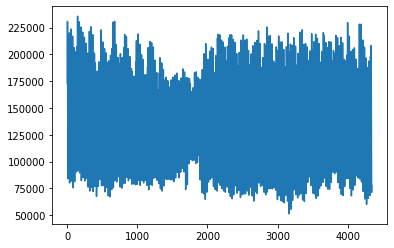

In [21]:
plt.plot(answer[:])

In [25]:
with open('lr_pred.txt', 'w') as f:
    for a in answer:
        f.write(str(a))
        f.write('\n')